In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True


In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi


In [4]:
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return gradient[0]

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
class MLPS(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPS, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

In [6]:
import time
input_size = 4
hidden_size = 200
output_size = 1

input_size_s = 4
hidden_size_s = 200
output_size_s = 6

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  h_nn = MLP(input_size, hidden_size, output_size).to(device)
  s_nn = MLPS(input_size_s, hidden_size_s, output_size_s).to(device)
  num_epochs = 2000
  criterion = nn.MSELoss()
  parmas = list(h_nn.parameters()) + list(s_nn.parameters())
  optimizer = optim.Adam(params=parmas,lr=0.001)

  history_loss = []
  history_eval = []
  history_acc = []
  startt = time.time()
  for epoch in range(num_epochs):
    estartt = time.time()
    h_nn.train()
    s_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4).to(device)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]
      
      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = output.squeeze(2)

      target = target.to(device)

      loss = criterion(output,target)
      loss.backward()
      optimizer.step()
    
      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt
  
    num_correct = 0
    num_data = 0
    h_nn.eval()
    s_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4).to(device)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]
      
      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = output.squeeze(2)

      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt

    history_loss.append(total_loss)
    history_eval.append(eval_loss)
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/skew_h_dp_v1_2t_{}".format(trial)
  torch.save(h_nn.state_dict(), path)
  path = "./model/skew_s_dp_v1_2t_{}".format(trial)
  torch.save(s_nn.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:0.00019468955579213799,evaluation loss:0.0002116408053552732
2000/2000 training loss:0.00018263937026858913,evaluation loss:0.0002450747400871478
2000/2000 training loss:0.0001925036960528814,evaluation loss:0.00023514445529144724
2000/2000 training loss:0.0002096889083077258,evaluation loss:0.00030367564031621443
2000/2000 training loss:0.0001925662189933064,evaluation loss:0.00023560780537081882
2000/2000 training loss:0.00020155009979134776,evaluation loss:0.00028852393152192237
2000/2000 training loss:0.00017951230438484345,evaluation loss:0.0002654930474818684
2000/2000 training loss:0.00020429666965355865,evaluation loss:0.0002648696343385382
2000/2000 training loss:0.00022255808571571833,evaluation loss:0.0003097528002399486
2000/2000 training loss:0.00020661905837187077,evaluation loss:0.00026541535917203876
train_loss:0.00019866239673319795, std: 1.2289508088052715e-05
test_loss:0.00026251982191752174, std: 2.9983975235424423e-05
computation_time:2248.3

In [8]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
#A = np.mat(A) # `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
#B = np.mat(B)
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.73424656 0.6566721  0.42773057 0.74193278]


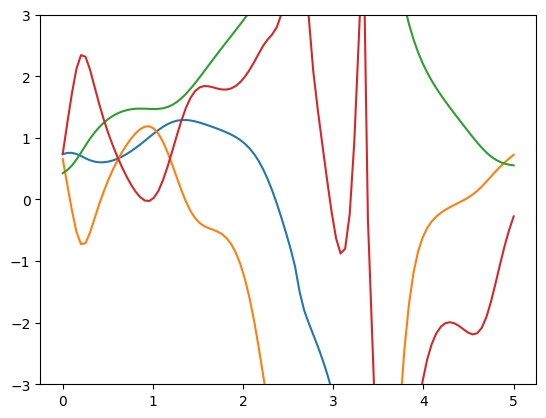

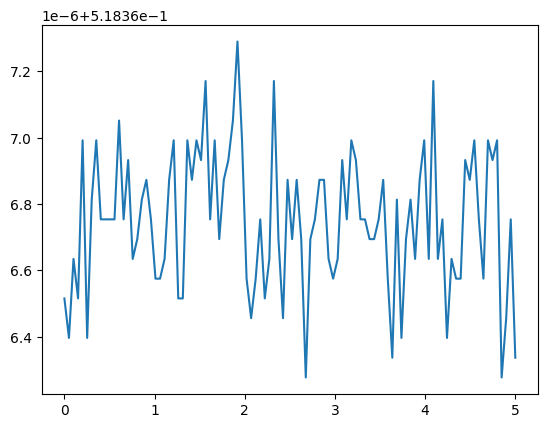

energy_error0:-1.7881393432617188e-07
energy_error0:2.991528578517743


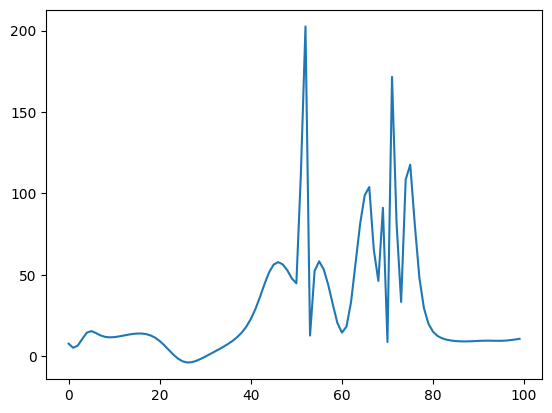

[0.3391952  0.01912268 0.42160305 0.99741402]


/tmp/ipykernel_37588/1942289074.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_37588/1942289074.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


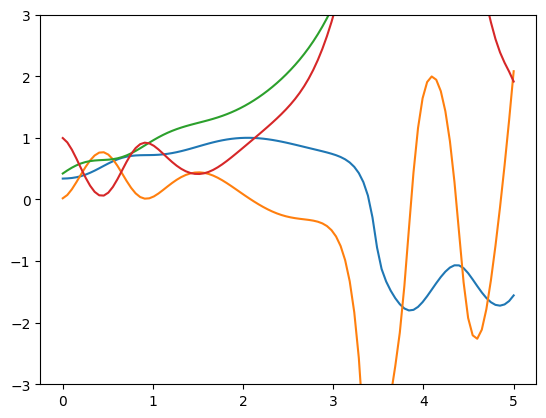

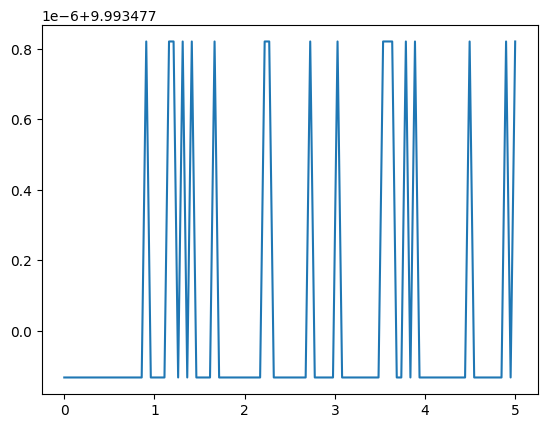

energy_error1:9.5367431640625e-07
energy_error1:189.98528672408113


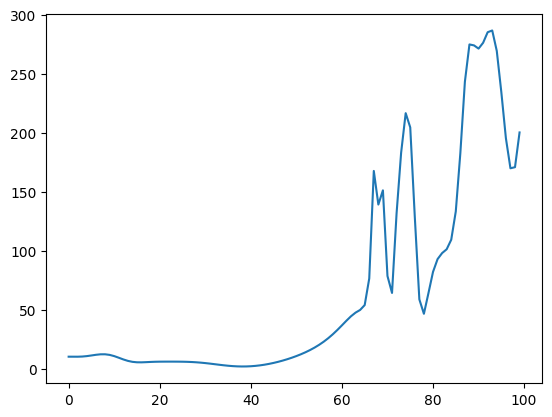

[0.03656911 0.92395591 0.23967218 0.95224603]


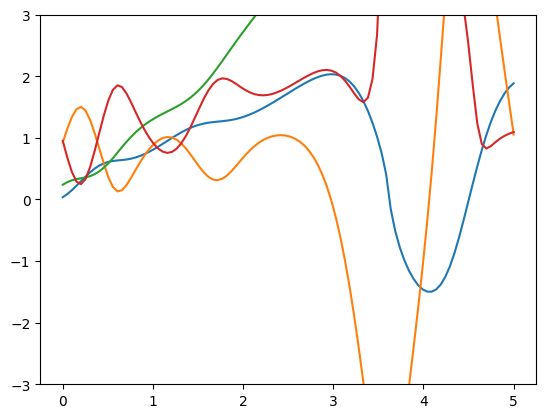

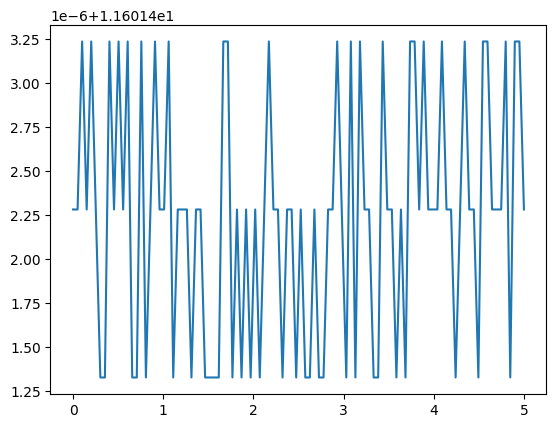

energy_error2:0.0
energy_error2:160.5730138336705


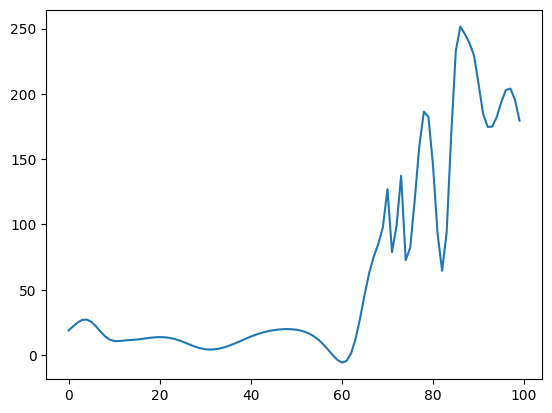

[0.26485681 0.29738391 0.98458253 0.46614086]


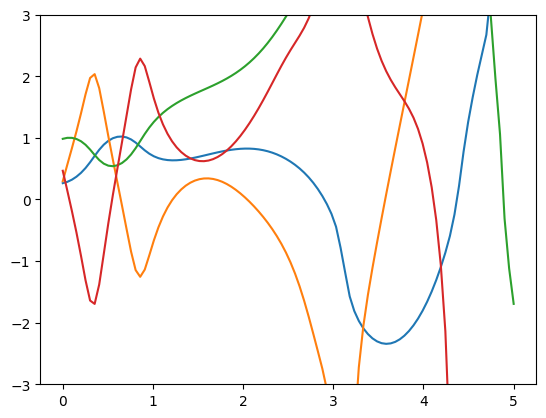

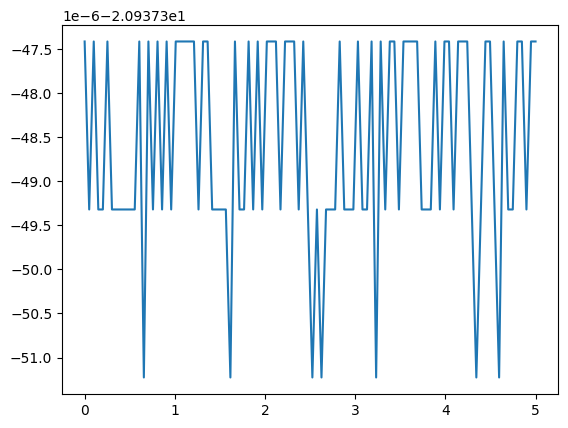

energy_error3:0.0
energy_error3:1563.7682968058148


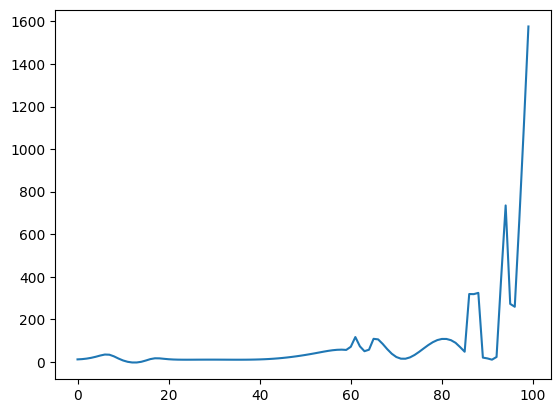

[0.95620719 0.08908681 0.10023305 0.73110729]


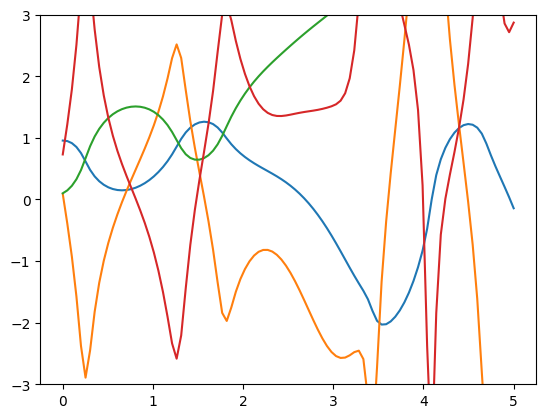

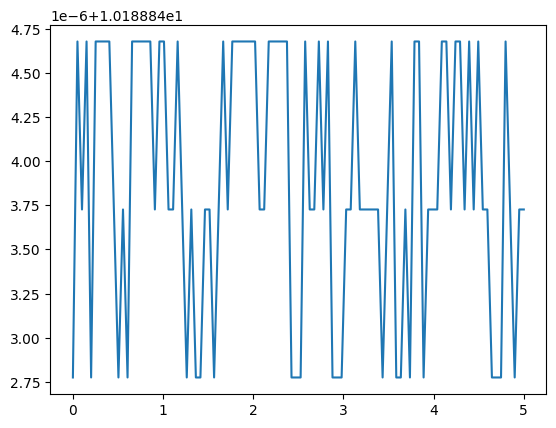

energy_error4:9.5367431640625e-07
energy_error4:118.62081904131252


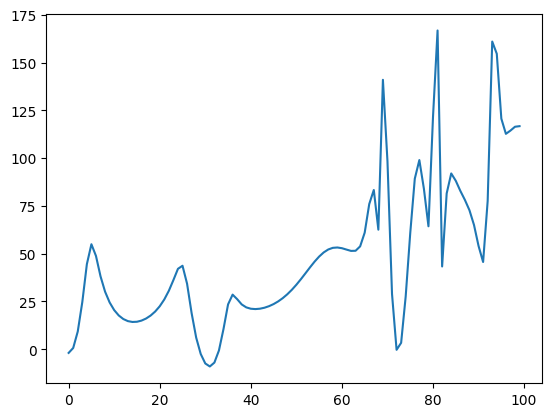

[0.56925707 0.38088485 0.51448741 0.89776162]


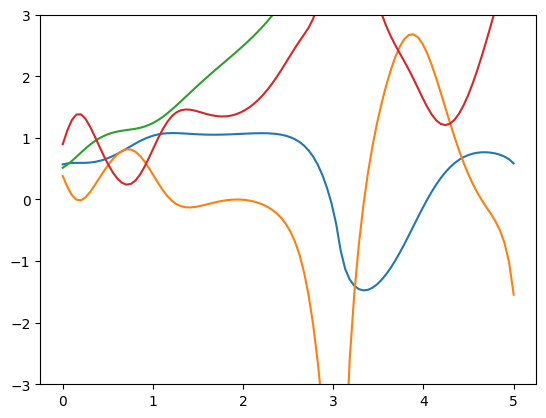

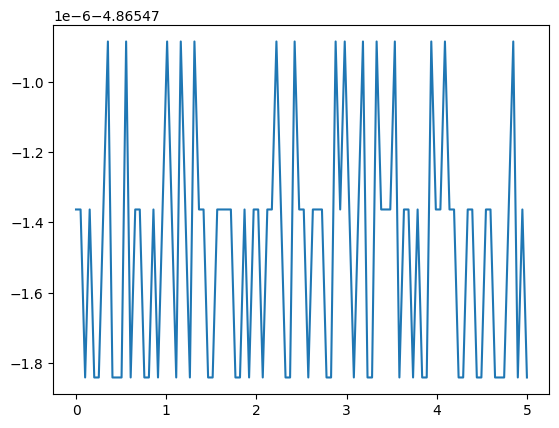

energy_error5:-4.76837158203125e-07
energy_error5:163.5761413568494


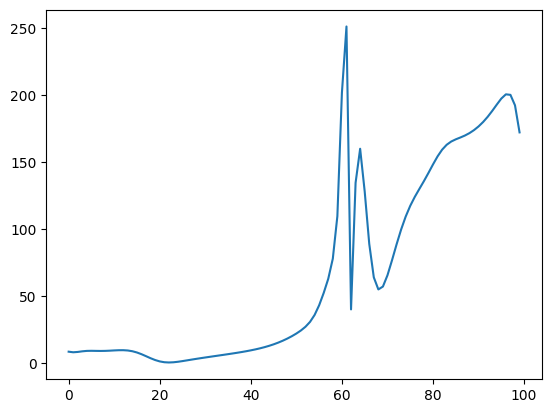

[0.57982002 0.89532277 0.52784278 0.28848429]


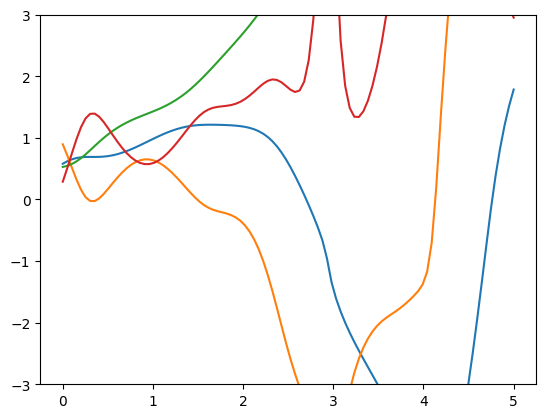

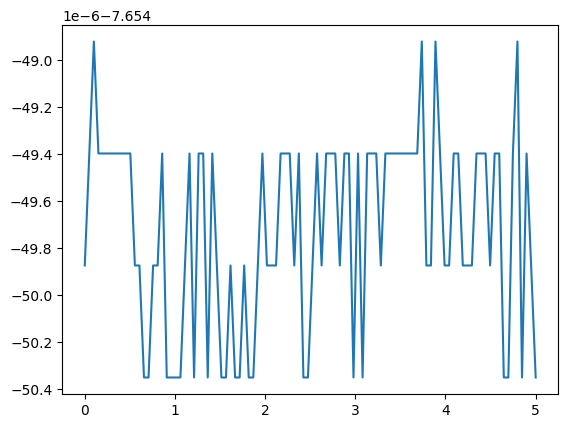

energy_error6:-4.76837158203125e-07
energy_error6:156.88078928971387


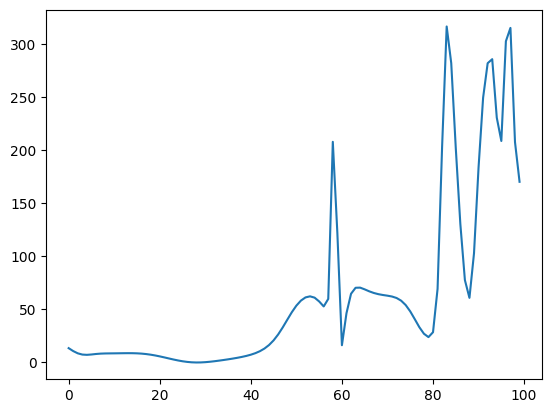

[0.40574935 0.55496527 0.98283737 0.54627115]


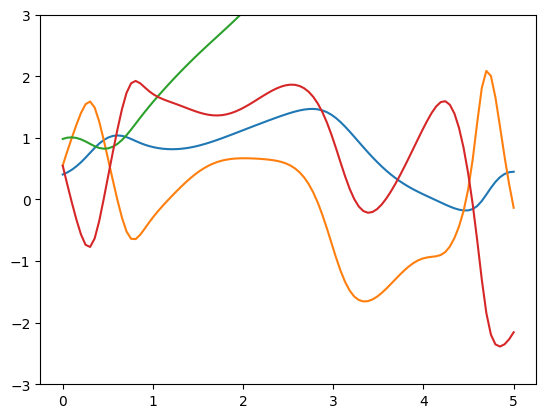

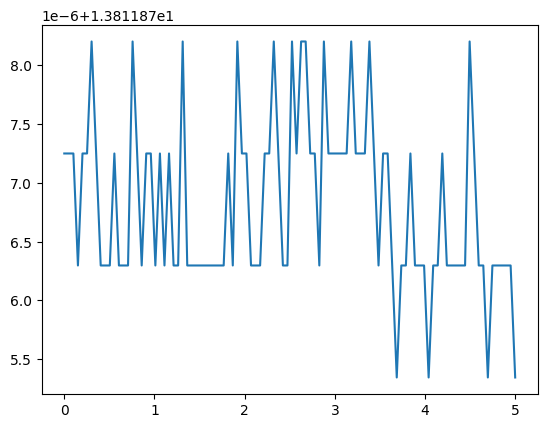

energy_error7:-1.9073486328125e-06
energy_error7:19.612123502907124


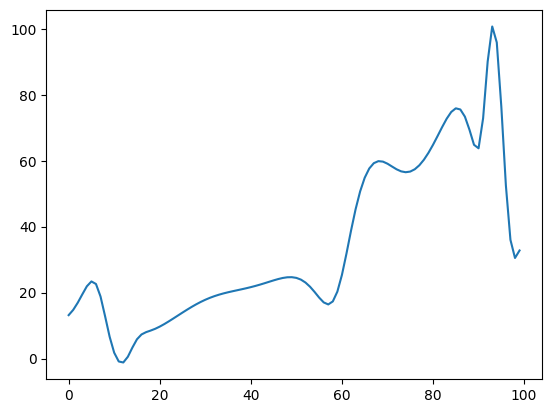

[0.63119862 0.3641424  0.44832169 0.35867564]


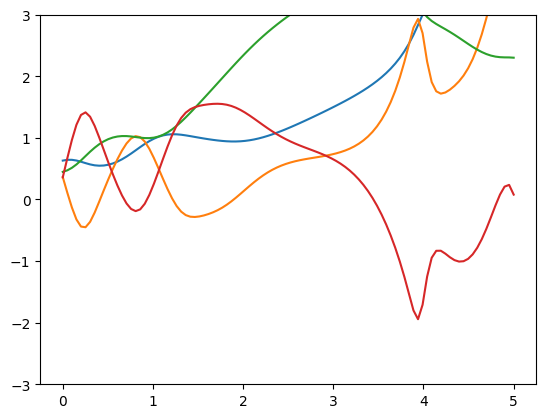

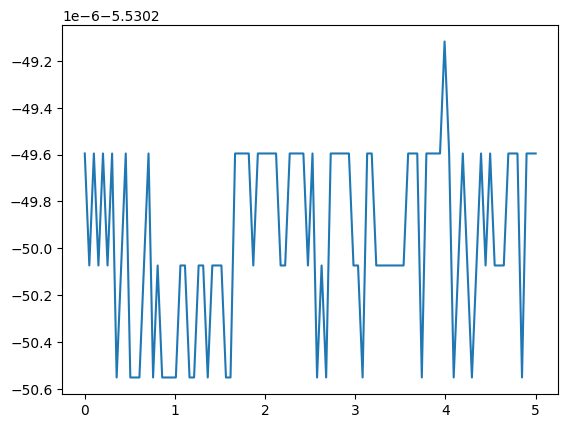

energy_error8:0.0
energy_error8:12.975498939829137


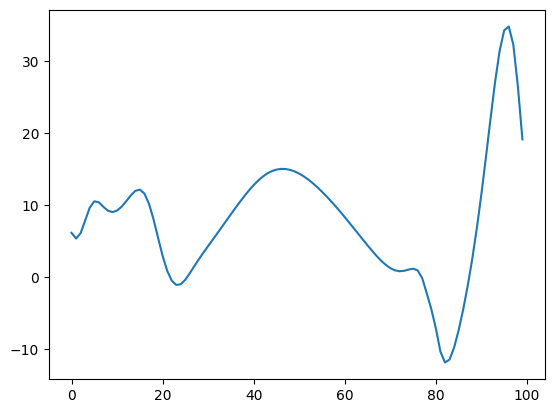

[0.17174863 0.36357341 0.30217936 0.96340619]


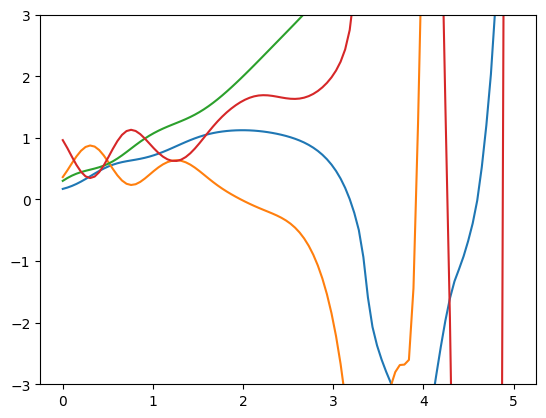

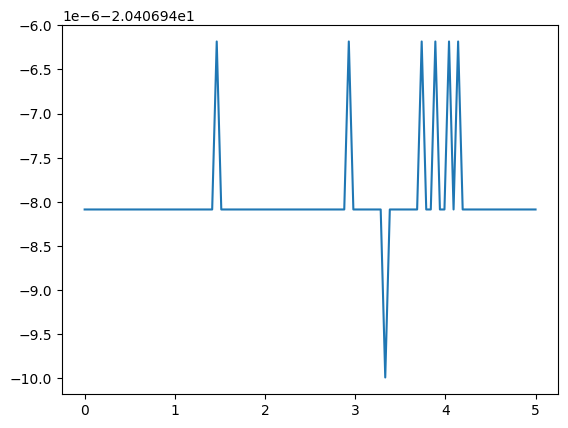

energy_error9:0.0
energy_error9:800.2630821130756


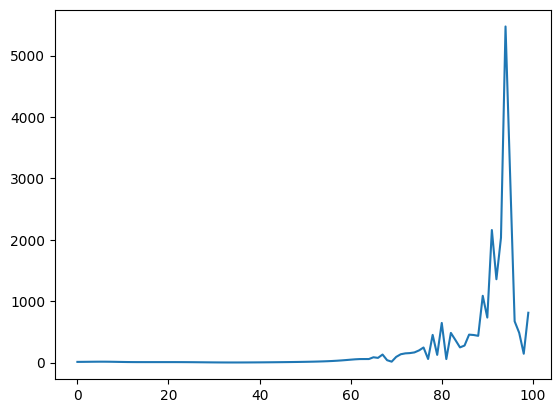

eq_error:[np.float64(2.991528578517743), np.float64(189.98528672408113), np.float64(160.5730138336705), np.float64(1563.7682968058148), np.float64(118.62081904131252), np.float64(163.5761413568494), np.float64(156.88078928971387), np.float64(19.612123502907124), np.float64(12.975498939829137), np.float64(800.2630821130756)] net_error:[np.float32(-1.7881393e-07), np.float32(9.536743e-07), np.float32(0.0), np.float32(0.0), np.float32(9.536743e-07), np.float32(-4.7683716e-07), np.float32(-4.7683716e-07), np.float32(-1.9073486e-06), np.float32(0.0), np.float32(0.0)]
eq_error:318.9246580185772, std: 468.6728706349805
net_error:4.94718563004426e-07, std: 7.625901048413652e-07


In [9]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
eq_error = []
net_error = []
for trial in range(num_trials):
  s_nn.load_state_dict(torch.load("./model/skew_s_dp_v1_2t_{}".format(trial), map_location=device))
  s_nn.eval()
  h_nn.load_state_dict(torch.load("./model/skew_h_dp_v1_2t_{}".format(trial), map_location=device))
  h_nn.eval()
  teval = torch.linspace(0.0,5.0,100)
  #x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  x0 = np.random.rand(4)
  print(x0)
  dt = teval[1]-teval[0]

  
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  h_nn.cpu()
  s_nn.cpu()
  def fvec_np(x, t):
      tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
      x = torch.matmul(tx, torch.inverse(B))
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]

      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = torch.matmul(A, output)
      output = output.squeeze(2)
      output = output.squeeze(0)
      return output.detach().cpu().numpy()
  res = scipy.integrate.odeint(fvec_np, x0, teval)

  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(teval,res[:,0])
  ax.plot(teval,res[:,1])
  ax.plot(teval,res[:,2])
  ax.plot(teval,res[:,3])
  plt.show()
  def net_energy(x,t):
    tx = torch.tensor(x, dtype=torch.float)
    x = torch.matmul(tx, torch.inverse(B))
    ne = h_nn(x).squeeze(0)
    return ne.detach().cpu().numpy()

  net_energy = net_energy(res, teval).reshape((100))
  plt.plot(teval,net_energy)
  plt.show()
  net_energy_error=net_energy[99]-net_energy[0]
  print("energy_error{}:{}".format(trial,net_energy_error))
    
  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)
  net_error.append(net_energy_error)
print("eq_error:{}".format(eq_error),"net_error:{}".format(net_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))
print("net_error:{}, std: {}".format(np.mean(np.abs(net_error)), np.std(net_error)))

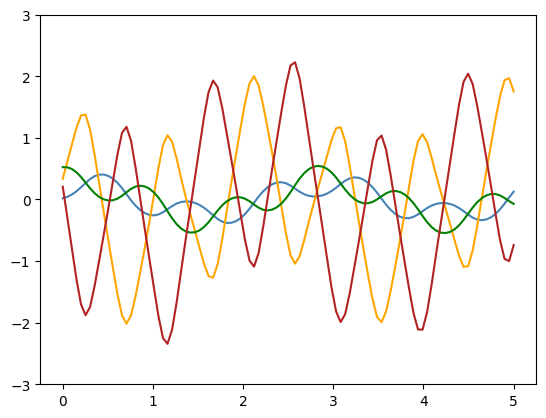

In [10]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
# equations of motion
def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(tval, q1, 'steelblue')
  ax.plot(tval, v1, 'orange')
  ax.plot(tval, q2, 'g')
  ax.plot(tval, v2, 'firebrick')
  plt.show()